# Silicon Absorption for Solar Cells

In [1]:
import jax.numpy as jnp
import numpy as onp
import scipy.constants as scic


import matplotlib.pyplot as plt

from jaxlayerlumos import stackrt
from jaxlayerlumos import utils_materials
from jaxlayerlumos import utils_spectra

from jaxlayerlumos import utils_position

from jaxlayerlumos import utils_units

## Silicon absorption on PEC

Crystalline silicon is the most common material for solar cells.  In this example, we simulate 150 micron thick silicon on PEC and make a plot of the absorption spectra.

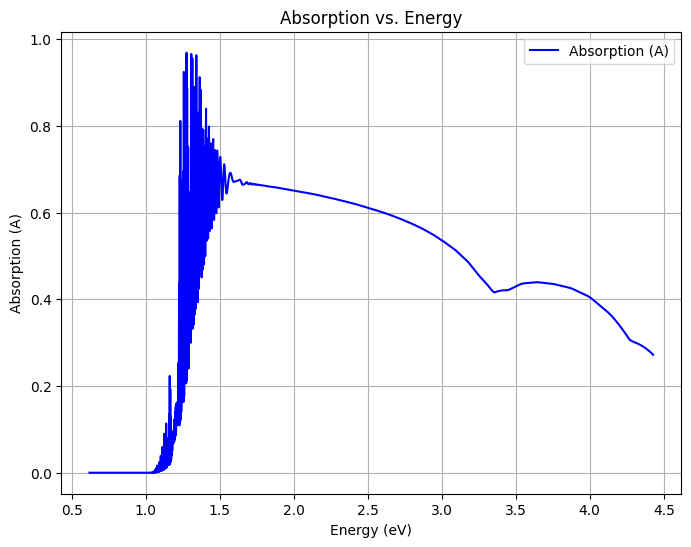

In [2]:
wavelengths = jnp.linspace(280e-9, 2000e-9, 1000)
frequencies = c / wavelengths

# PEC is a perfect electrical conductor
materials = onp.array(["Air", "cSi", "PEC"])
thickness_materials = [0, 40e-6, 0]

thicknesses = jnp.array(thickness_materials)
n_k = utils_materials.get_n_k(materials, frequencies)

R_TE, T_TE, R_TM, T_TM = stackrt(n_k, thicknesses, frequencies, 0.0)

A = 1 - R_TE - T_TE
energy = utils_spectra.convert_wavelengths_to_energy(wavelengths)
plt.figure(figsize=(8, 6))
plt.plot(energy, A.squeeze(), label="Absorption (A)", color="b")
plt.xlabel("Energy (eV)")
plt.ylabel("Absorption (A)")
plt.title("Absorption vs. Energy")
plt.grid(True)
plt.legend()
plt.show()



## Silicon absorption on Aluminum

sHere we switch the back layer to Aluminum instead of a perfect electrical conductor (PEC).  Since the Aluminum has some parasitic absorption, we must calculate the absorption in each layer.
There is a very slight difference with aluminum, but it is small so we can just use PEC. As can be seen, most of the absorption in the aluminum occurs at smaller energies and thus can be absorbed.

In [3]:
# PEC is a perfect electrical conductor
materials = onp.array(["Air", "cSi", "Al"])
thickness_materials = [0, 40e-6, 0]
material_silicon_index = 2
material_aluminum_index = 3

thicknesses = jnp.array(thickness_materials)
n_k = utils_materials.get_n_k(materials, frequencies)
theta_inc = 0
# We have to also get the coefficients back
R_TE, T_TE, R_TM, T_TM, results_coeffs = stackrt(
        n_k, thicknesses, frequencies, theta_inc, return_coeffs = True
    )

results_coeffs = utils_position.calc_absorption_in_each_layer(
    thicknesses, results_coeffs
)
# results_coeffs["absorption_layer_TE"][material_silicon_index-1,:]

energy = utils_spectra.convert_wavelengths_to_energy(wavelengths)
plt.figure(figsize=(8, 6))
plt.plot(energy, results_coeffs["absorption_layer_TE"][material_silicon_index-1,:], label='Al substrate', color="g")
plt.plot(energy, A.squeeze(), label='PEC substrate', color="b")
# plt.plot(energy, A.squeeze(), label="Absorption (A)", color="b")
plt.xlabel("Energy (eV)")
plt.ylabel("Absorption (A)")
plt.title("Absorption vs. Energy")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(energy, results_coeffs["absorption_layer_TE"][material_aluminum_index-1,:], label='Al substrate Absorption', color="r")
# plt.plot(energy, A.squeeze(), label="Absorption (A)", color="b")
plt.xlabel("Energy (eV)")
plt.ylabel("Absorption (A)")
plt.title("Aluminum Absorption vs. Energy in Aluminum Layer")
plt.grid(True)




NameError: name 'frequencies' is not defined

## Solar Absorption

We want to calculate the solar absorption as a function of thickness.

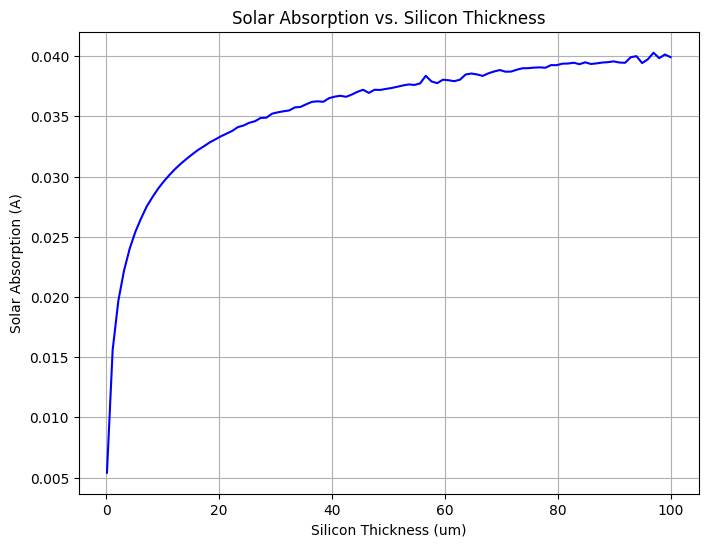

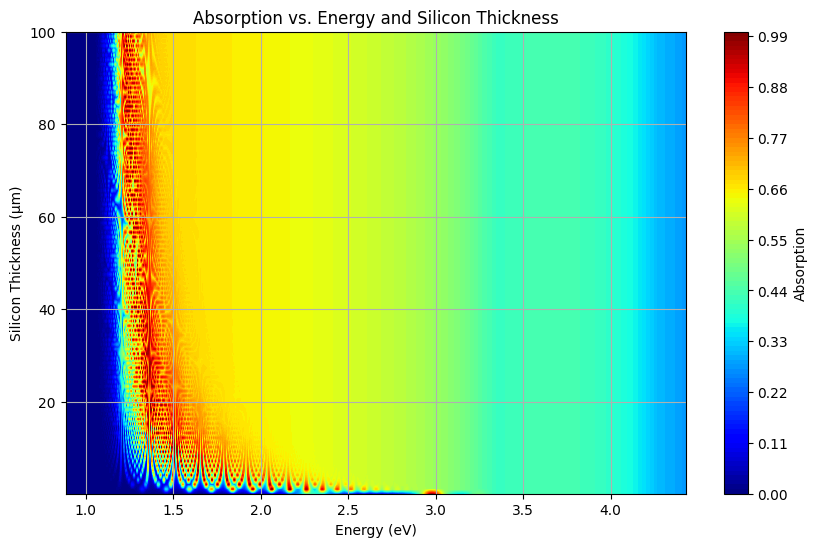

In [15]:
wavelengths = jnp.linspace(280e-9, 1400e-9, 1000)
frequencies = scic.c / wavelengths

silicon_thicknesses = jnp.linspace(100e-9, 100e-6, 100)

# PEC is a perfect electrical conductor
materials = onp.array(["Air", "cSi", "PEC"])

solar_absorption_results = []

wavelengths_all = jnp.linspace(280e-9, 4000e-9, 2000)
irradiance_all = utils_spectra.get_irradiance('AM1p5G', wavelengths_all)
photon_flux_all = (irradiance_all * wavelengths_all)/(scic.h*scic.c)
total_photons = onp.trapezoid(photon_flux_all, wavelengths_all)
n_k = utils_materials.get_n_k(materials, frequencies)

absorption_results = onp.zeros((len(silicon_thicknesses), len(wavelengths)))

for i, thickness_si in enumerate(silicon_thicknesses):

    thickness_materials = [0, thickness_si, 0]

    thicknesses = jnp.array(thickness_materials)

    R_TE, T_TE, R_TM, T_TM = stackrt(n_k, thicknesses, frequencies, 0.0)
    A = 1 - R_TE - T_TE

    irradiance = utils_spectra.get_irradiance('AM1p5G', wavelengths)
    photon_flux = (irradiance * wavelengths)/(scic.h*scic.c)
    energy = utils_units.get_light_speed()* scic.h/ wavelengths/scic.e
    absorption_results[i,:] = A
    solar_absorption = onp.trapezoid(A * photon_flux, wavelengths)/total_photons
    solar_absorption_results.append(solar_absorption)

solar_absorption_results = onp.array(solar_absorption_results)

silicon_thicknesses_micron = silicon_thicknesses*1e6
plt.figure(figsize=(8, 6))
plt.plot(silicon_thicknesses_micron, solar_absorption_results, label='Solar Absorption', color="b")
# plt.plot(energy, A.squeeze(), label="Absorption (A)", color="b")
plt.xlabel("Silicon Thickness (um)")
plt.ylabel("Solar Absorption (A)")
plt.title("Solar Absorption vs. Silicon Thickness")
plt.grid(True)

X, Y = onp.meshgrid(energy, silicon_thicknesses_micron)
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, absorption_results, levels=100, cmap = 'jet')
plt.colorbar(label='Absorption')
plt.xlabel('Energy (eV)')
plt.ylabel('Silicon Thickness (µm)')
plt.title('Absorption vs. Energy and Silicon Thickness')
plt.grid(True)
plt.show()


